source: https://www.kaggle.com/code/robikscube/train-your-first-pytorch-model-card-classifier#Bonus:-Evaluating-the-Results

In [17]:
# Pytorch
import torch
from torch import nn
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import Dataset, DataLoader

# Torchvision: make working with image files easier
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# progress bar
from tqdm import tqdm 

# optimizer
import torch.optim as optim

In [18]:
class SyntheticDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform) 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes # returns dataset classes from ImageFolder

In [19]:
class SyntheticDataClassifier(nn.Module):
    def __init__(self, num_classes=2, weights='DEFAULT'):
        super(SyntheticDataClassifier, self).__init__()
        self.model = resnet18(weights=weights)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)  # Modify the last fully connected layer
    
    def forward(self, x):
        return self.model(x)

In [20]:
# Define the transformation operation that suits resnet18
weights = ResNet18_Weights.DEFAULT
transform_operation = weights.transforms() 

# Create a dataset object
train_data = SyntheticDataset(data_dir='dataset\\train', transform=transform_operation)
test_data = SyntheticDataset(data_dir='dataset\\test', transform=transform_operation)

# Create a DataLoader object for training - faster training in batches
train_loader = DataLoader(train_data, batch_size=32, shuffle=True) 
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [21]:
# Training the model
num_epochs = 5
train_losses = []
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
    
model = SyntheticDataClassifier(num_classes=2, weights=weights).to(device)    
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc='Training loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * labels.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}")

Training loop:  33%|███▎      | 3/9 [00:09<00:18,  3.09s/it]

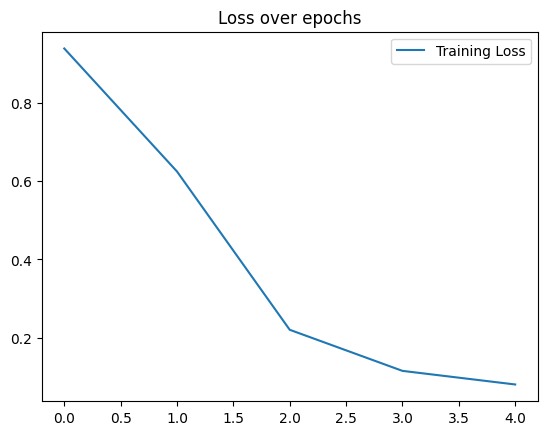

In [14]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

# Test dataset to determine the accuracy

In [16]:
model.eval()

# Initialize variables for accuracy calculation
correct = 0
total = 0

# Disable gradient computation
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        # Move images and labels to the device (assuming you're using GPU)
        images, labels = images.cuda(), labels.cuda()
        
        # Forward pass
        outputs = model(images)
        
        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        
        # Total number of labels
        total += labels.size(0)
        
        # Total correct predictions
        correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print('Accuracy on the test set: {:.2f}%'.format(accuracy))

AssertionError: Torch not compiled with CUDA enabled

# Inference

In [10]:
# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

In [12]:
# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

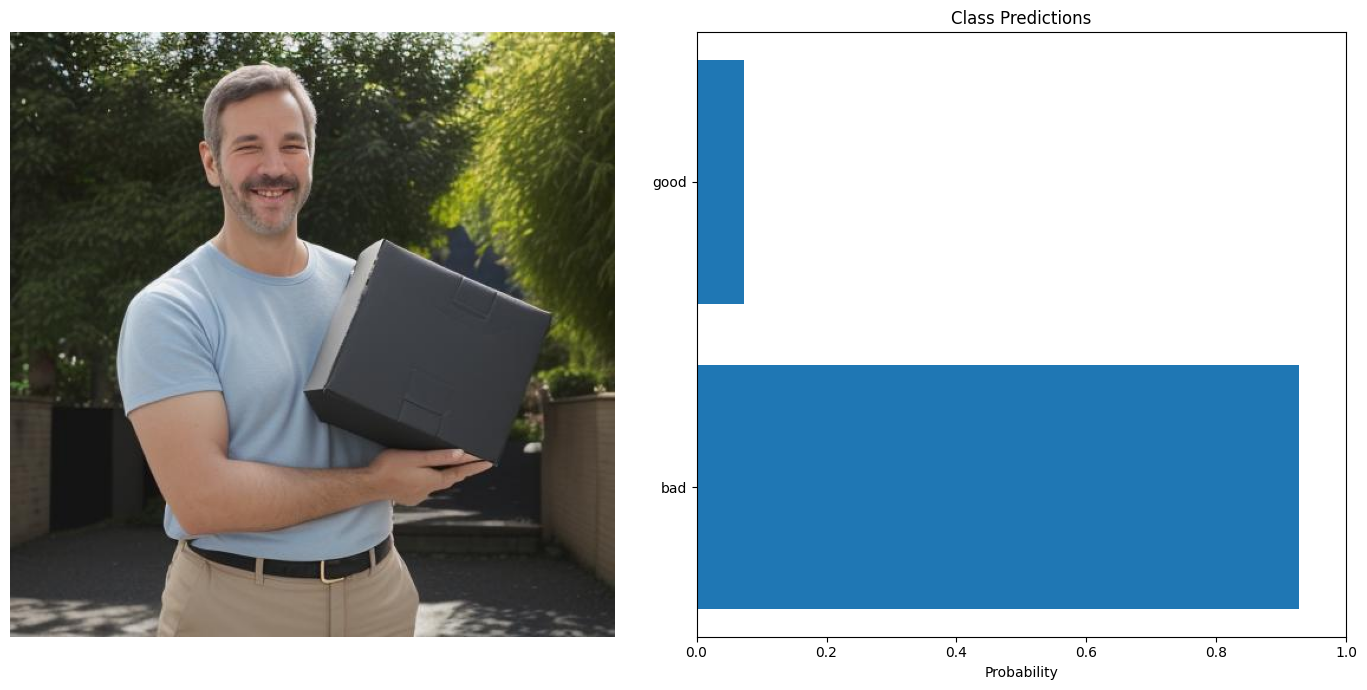

[0.9271895  0.07281046]


In [38]:
from PIL import Image
# Example usage
test_image = "data\\129_2.jpg"
original_image, image_tensor = preprocess_image(test_image, transform_operation) # determined earlier in the code
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = train_data.classes 
visualize_predictions(original_image, probabilities, class_names)
print(probabilities)

In [32]:
# Run inference write to directory
import os

directory = 'data\\'
files = os.listdir(directory)
sorted_files = sorted(files, key=lambda x: (int(x.split('_')[0]), int(x.split('_')[1].split('.')[0])))

['1_1.jpg', '1_2.jpg', '1_3.jpg', '1_4.jpg', '1_5.jpg', '2_1.jpg', '2_2.jpg', '2_3.jpg', '2_4.jpg', '2_5.jpg', '3_1.jpg', '3_2.jpg', '3_3.jpg', '3_4.jpg', '3_5.jpg', '4_1.jpg', '4_2.jpg', '4_3.jpg', '4_4.jpg', '4_5.jpg', '5_1.jpg', '5_2.jpg', '5_3.jpg', '5_4.jpg', '5_5.jpg', '6_1.jpg', '6_2.jpg', '6_3.jpg', '6_4.jpg', '6_5.jpg', '7_1.jpg', '7_2.jpg', '7_3.jpg', '7_4.jpg', '7_5.jpg', '8_1.jpg', '8_2.jpg', '8_3.jpg', '8_4.jpg', '8_5.jpg', '9_1.jpg', '9_2.jpg', '9_3.jpg', '9_4.jpg', '9_5.jpg', '10_1.jpg', '10_2.jpg', '10_3.jpg', '10_4.jpg', '10_5.jpg', '11_1.jpg', '11_2.jpg', '11_3.jpg', '11_4.jpg', '11_5.jpg', '12_1.jpg', '12_2.jpg', '12_3.jpg', '12_4.jpg', '12_5.jpg', '13_1.jpg', '13_2.jpg', '13_3.jpg', '13_4.jpg', '13_5.jpg', '14_1.jpg', '14_2.jpg', '14_3.jpg', '14_4.jpg', '14_5.jpg', '15_1.jpg', '15_2.jpg', '15_3.jpg', '15_4.jpg', '15_5.jpg', '16_1.jpg', '16_2.jpg', '16_3.jpg', '16_4.jpg', '16_5.jpg', '17_1.jpg', '17_2.jpg', '17_3.jpg', '17_4.jpg', '17_5.jpg', '18_1.jpg', '18_2.jpg', 

In [43]:
for file in sorted_files:
    
    original_image, image_tensor = preprocess_image("data\\" + file, transform_operation) # determined earlier in the code
    probabilities = predict(model, image_tensor, device)
    print(probabilities)
    
    if probabilities[0] < probabilities[1]:
        print(f"Image {file} is good, writing to good directory")
        original_image.save(f'results\\good\\{file}')
    else:
        print(f"Image {file} is bad, writing to bad directory")
        original_image.save(f'results\\bad\\{file}')

[9.9997997e-01 2.0001218e-05]
Image 1_1.jpg is bad, writing to bad directory
[2.6556253e-04 9.9973446e-01]
Image 1_2.jpg is good, writing to good directory
[0.919494   0.08050598]
Image 1_3.jpg is bad, writing to bad directory
[0.94736284 0.05263722]
Image 1_4.jpg is bad, writing to bad directory
[0.99825865 0.00174132]
Image 1_5.jpg is bad, writing to bad directory
[0.13197033 0.8680297 ]
Image 2_1.jpg is good, writing to good directory
[4.4982782e-05 9.9995506e-01]
Image 2_2.jpg is good, writing to good directory
[1.0000000e+00 2.9068035e-09]
Image 2_3.jpg is bad, writing to bad directory
[0.9927977  0.00720231]
Image 2_4.jpg is bad, writing to bad directory
[0.6953472 0.3046528]
Image 2_5.jpg is bad, writing to bad directory
[8.185671e-10 1.000000e+00]
Image 3_1.jpg is good, writing to good directory
[0.8029706 0.1970294]
Image 3_2.jpg is bad, writing to bad directory
[0.0207191 0.9792809]
Image 3_3.jpg is good, writing to good directory
[0.01497467 0.98502535]
Image 3_4.jpg is good